In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import sys
import os
import umap
from sklearn.metrics import silhouette_score

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *


In [37]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

latent_rep_path = os.path.join(base_dir, 'latent_representation.csv')
latent_rep = pd.read_csv(latent_rep_path, index_col='customer_id')

In [38]:
scaler = MinMaxScaler()
latent_rep_scaled = pd.DataFrame(scaler.fit_transform(latent_rep), columns=latent_rep.columns, index=latent_rep.index)

In [39]:
latent_rep_scaled.head(3)

,latent_0,latent_1,latent_2,latent_3
customer_id,,,,
26709,0.351277,0.455748,0.601716,0.345119
47768,0.357316,0.327743,0.245954,0.261178
29757,0.550426,0.341741,0.309953,0.229338


In [5]:
db = DBSCAN(eps=0.1, min_samples=15)

# Fit the model to your data
db.fit(latent_rep_scaled)

latent_rep_scaled['cluster'] = db.labels_ 

# Identify outliers
outliers = latent_rep_scaled[db.labels_ == -1]

In [7]:
latent_rep_scaled

,latent_0,latent_1,latent_2,latent_3,cluster
customer_id,,,,,
26709,0.351277,0.455748,0.601716,0.345119,0
47768,0.357316,0.327743,0.245954,0.261178,0
29757,0.550426,0.341741,0.309953,0.229338,0
42493,0.391510,0.872132,0.837180,0.696681,0
27655,0.206095,0.403794,0.621290,0.443428,0
...,...,...,...,...,...
22316,0.271850,0.241628,0.351646,0.420662,0
46617,0.358416,0.108119,0.549362,0.355993,0
5477,0.301920,0.694391,0.788505,0.615984,0


In [21]:
len(latent_rep)

22732

c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


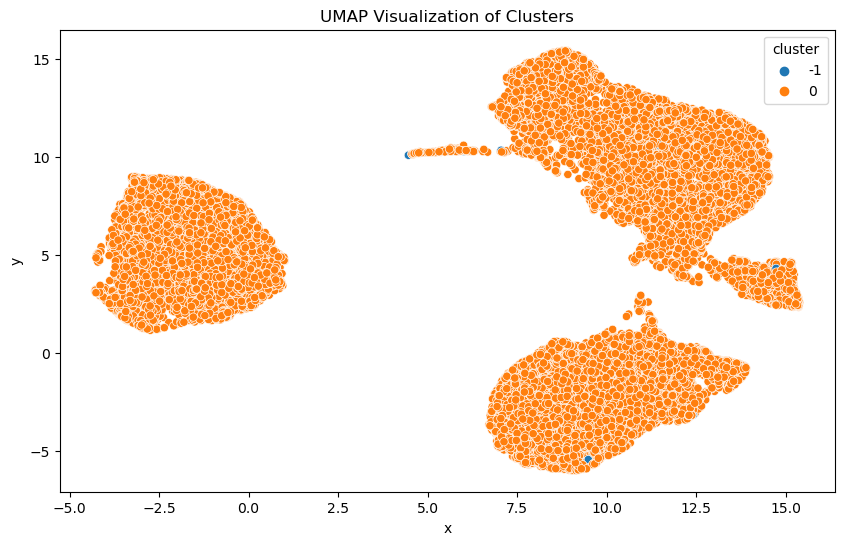

In [8]:
plot_umap_clusters(latent_rep_scaled)

In [16]:
# Define the parameter space
eps_values = [0.1, 0.15, 0.2, 0.25, 0.3]
min_samples_values = [5, 10, 15, 20, 25]

# Initialize the best parameters and the best score
best_eps = None
best_min_samples = None
best_score = -1

# Perform Grid Search
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(latent_rep_scaled)
        labels = db.labels_
        
        # Skip silhouette score calculation if there is only one unique label
        if len(np.unique(labels)) > 1:
            score = silhouette_score(latent_rep_scaled, labels)
            if score > best_score:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")

Best eps: 0.1
Best min_samples: 15


In [23]:
from sklearn.ensemble import IsolationForest

# Create an instance of Isolation Forest
clf = IsolationForest(contamination=0.05)

# Fit the model to your data
clf.fit(latent_rep_scaled)

# Predict the outliers
outliers = clf.predict(latent_rep_scaled)

# Add the cluster column to the dataframe
latent_rep_scaled['cluster'] = outliers

c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [24]:
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
latent_rep_scaled['cluster'].value_counts()

cluster
 1    21595
-1     1137
Name: count, dtype: int64

c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


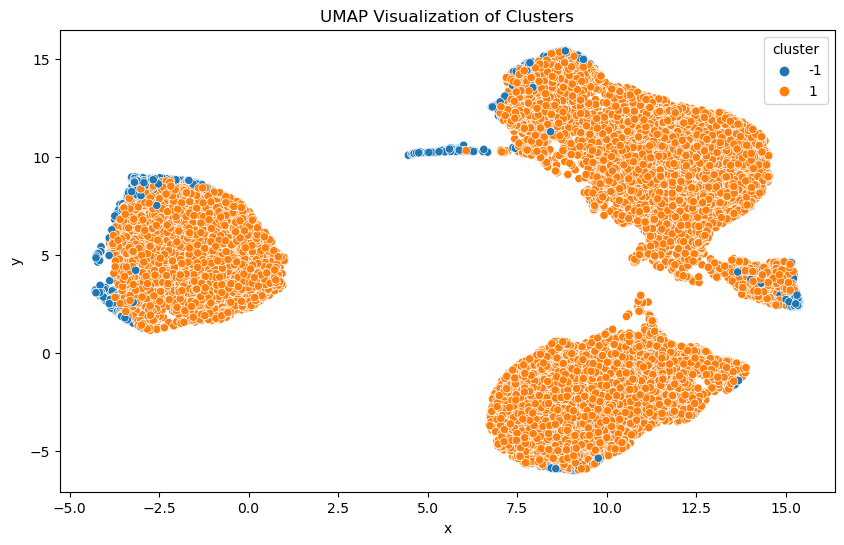

In [26]:
plot_umap_clusters(latent_rep_scaled)

In [27]:
latent_rep_scaled = latent_rep_scaled[latent_rep_scaled['cluster'] == 1]


In [28]:
latent_rep_scaled.drop('cluster', axis=1, inplace=True) 

In [29]:
latent_rep_scaled

,latent_0,latent_1,latent_2,latent_3
customer_id,,,,
26709,0.351277,0.455748,0.601716,0.345119
47768,0.357316,0.327743,0.245954,0.261178
29757,0.550426,0.341741,0.309953,0.229338
27655,0.206095,0.403794,0.621290,0.443428
28439,0.385917,0.369016,0.325334,0.250801
...,...,...,...,...
22316,0.271850,0.241628,0.351646,0.420662
46617,0.358416,0.108119,0.549362,0.355993
5477,0.301920,0.694391,0.788505,0.615984


c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

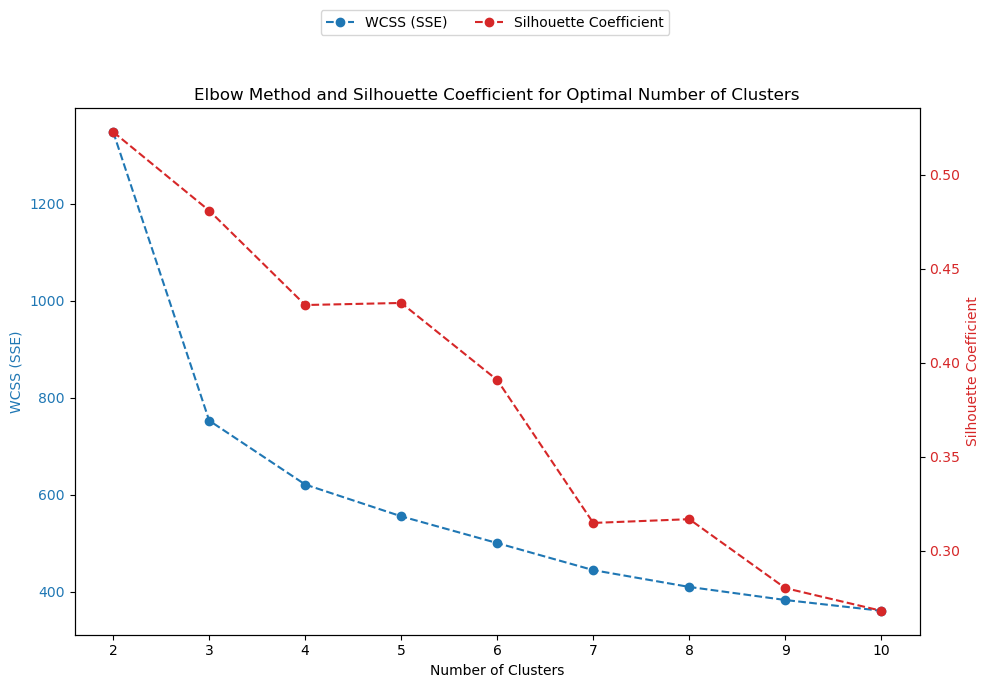

([1347.76891270317,
  752.7426421783255,
  620.9768441665841,
  555.4463620209767,
  500.29693576331255,
  444.5286787456647,
  409.8693902432975,
  382.9257610704045,
  360.7245934724431],
 [0.5228417607721773,
  0.48095677442355783,
  0.4307070926954247,
  0.43181066444772775,
  0.390767467130795,
  0.31471248997999807,
  0.3167087068436391,
  0.2800143460340123,
  0.2679432548749734])

In [13]:
plot_elbow_and_silhouette(latent_rep_scaled)

In [33]:
latent_rep_scaled_a = append_kmeans_clusters(latent_rep_scaled, 4)

c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


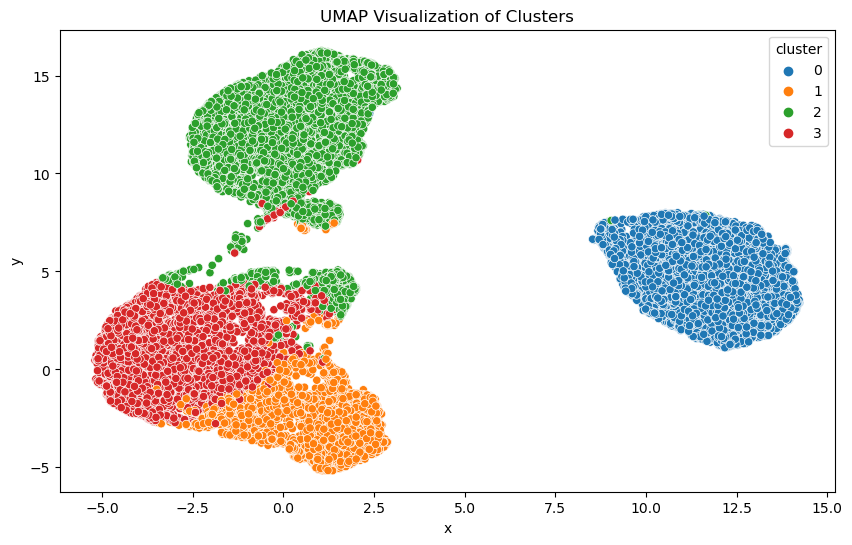

In [34]:
plot_umap_clusters(latent_rep_scaled_a)

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_clusters(df, random_state=42):
    """
    Use t-SNE to plot clusters in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame, which must contain a 'cluster' column.
    random_state (int): The random state for reproducibility.

    Returns:
    None
    """
    if 'cluster' not in df.columns:
        raise ValueError("DataFrame must contain a 'cluster' column.")
    
    features = df.drop(columns='cluster')
    labels = df['cluster']
    
    tsne_model = TSNE(n_components=2, random_state=random_state)
    tsne_components = tsne_model.fit_transform(features)
    
    tsne_df = pd.DataFrame(tsne_components, columns=['x', 'y'])
    tsne_df['cluster'] = labels.values
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='x', y='y', hue='cluster', data=tsne_df, palette='tab10')
    plt.title('t-SNE Visualization of Clusters')
    plt.show()

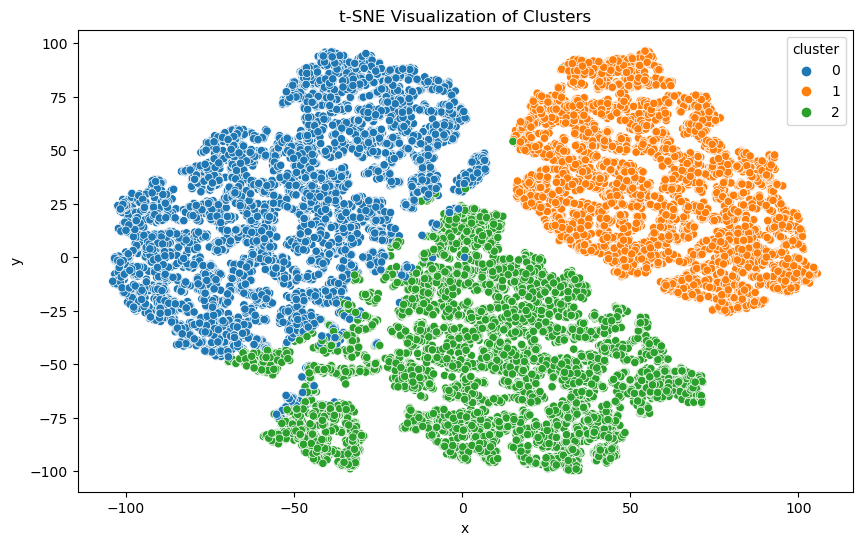

In [18]:
plot_tsne_clusters(latent_rep_scaled_a)